# Notebook for knowledge tracing by topics

## Brief overview of Lernnavi
[Lernnavi](https://www.lernnavi.ch) is an instrument for promoting part of the basic technical study skills in German and mathematics.

Lernnavi's dataset is formatted in three main tables:
* *users*: demographic information of users.
* *events*: events done by the users in the platform.
* *transactions*: question and answer solved by user.


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

# Scikit-learn package imports
from sklearn import feature_extraction, model_selection, metrics

# PyBKT package imports
from pyBKT.models import Model

# PyAFM package imports
from pyafm.custom_logistic import CustomLogistic

DATA_DIR = 'data' # You many change the directory

users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

In [2]:
topics=pd.read_csv('{}/topics_translated.csv.gz'.format(DATA_DIR))
topics_trees=pd.read_csv('{}/topic_trees.csv.gz'.format(DATA_DIR))
documents=pd.read_csv('{}/documents.csv.gz'.format(DATA_DIR))
learn_sessions=pd.read_csv('{}/learn_sessions_transactions.csv.gz'.format(DATA_DIR))

In [3]:
transactions['user_id']=transactions['user_id'].astype(int)

## Task 1: Data Preprocessing

We consider:
- partial answers as incorrect
- answers can be given only on tasks of type 'level check'
- only accepted by users sessions
- any sessions by closeness
- users with any number of sessions

In [4]:
learn_transaction=pd.merge(learn_sessions,transactions[['transaction_id','user_id','evaluation']],on='transaction_id').copy()

In [5]:
#We assume that answers can be given only on tasks of lype check and no answers on tasks of type learn
learn_transaction=learn_transaction[((learn_transaction['type_id']==2)  & (learn_transaction['evaluation'].notna())) | ((learn_transaction['type_id']==1)  & (learn_transaction['evaluation'].isna()))].copy()

In [6]:
learn_transaction['correct']=learn_transaction['evaluation'].fillna(-1) #not given
learn_transaction['correct']=np.where((learn_transaction['correct']=='CORRECT') ,1,np.where(learn_transaction['correct']==-1,-1,0)) #PARTIAL as incorrect
#learn_transaction['correct']=np.where((learn_transaction['correct']=='CORRECT') & (learn_transaction['correct']=='PARTIAL'),1,np.where(learn_transaction['correct']==-1,-1,0)) #PARTIAL as correct

In [7]:
learn_transaction=pd.merge(learn_transaction,topics,left_on='topic_id',right_on='id').copy()

In [8]:
learn_transaction=learn_transaction[learn_transaction['is_accepted']==1].reset_index().copy()

In [9]:
learn_transaction['subject']=np.where(learn_transaction['math']==1,'Math','German')

In [10]:
df_topic=learn_transaction[['user_id','learn_session_id','transaction_id','name_english','correct']].sort_values(by=['learn_session_id','transaction_id'],ascending=True)
df_topic=df_topic.rename(columns={"name_english": "skill_name"}).copy()

In [11]:
df_topic['prior_success']=np.where(df_topic.correct==1,1,0)
df_topic['prior_failure']=np.where(df_topic.correct==0,1,0)
df_topic['prior_success']=df_topic.groupby(['user_id','skill_name']).prior_success.cumsum()-1
df_topic['prior_success']=df_topic['prior_success'].apply(lambda x: 0 if x<0 else x)
df_topic['prior_failure']=df_topic.groupby(['user_id','skill_name']).prior_failure.cumsum()-1
df_topic['prior_failure']=df_topic['prior_failure'].apply(lambda x: 0 if x<0 else x)

Most popular topics

In [12]:
#Take top n topics to analyze over them
n=5
top_topics=df_topic.groupby('skill_name').count().sort_values(by='user_id',ascending=False)[0:n].index

Least popular topics

In [12]:
#Take last n topics to analyze over them
# n=10
# top_topics=df_topic.groupby('skill_name').count().sort_values(by='user_id',ascending=False)[-n:].index

In [13]:
top_topics

Index(['Evidence by congruence', 'Connectors', 'Switching formulas',
       'Inequality', 'General triangles, sinus and cosine',
       'Sentence group of the Pythagoras', 'Circle and circle parts',
       'Gray equations that lead to linear equations',
       'Text tasks on linear equations', 'Elemental geometry - basics',
       'Macrostructure', 'Translations of functional graphs',
       'Relationship between phrases / attributes and sidelines',
       'Functional values ​​of sinus, cosinus, tangens',
       'Bowmass - Definition, Conversions in GradeMass and values ​​of trigonometric functions'],
      dtype='object', name='skill_name')

In [14]:
df_topic=df_topic[df_topic['skill_name'].isin(top_topics)].reset_index(drop=True)
df_topic

,user_id,learn_session_id,transaction_id,skill_name,correct,prior_success,prior_failure
0,387605,5432,387905,Connectors,-1,0,0
1,387615,5557,388232,Connectors,-1,0,0
2,387741,6134,390991,Translations of functional graphs,-1,0,0
3,387741,6134,390995,Translations of functional graphs,-1,0,0
4,387741,6134,390997,Translations of functional graphs,-1,0,0
...,...,...,...,...,...,...,...
2568,404578,111906,1582951,Evidence by congruence,1,8,3
2569,404578,111920,1582978,Evidence by congruence,0,8,4
2570,404578,111920,1582990,Evidence by congruence,1,9,4
2571,404578,111920,1582991,Evidence by congruence,0,9,5


In [17]:
np.shape(df_topic)

(2573, 7)

## Task 2: Model Building
----
In this section, we perform: 

(i) a Bayesian Knowledge Tracing (BKT) model, 

(ii) an Additive Factor Model (AFM),

(iii) a Performance Factor Analysis (PFA) model and 

(iv) a Deep learning knowledge tracing (DKT) model <br>
on the most/least popular topics.

We will complete this section through four main tasks:

Task 2.1: Group k-fold initialization.

Task 2.2: BKT evaluation.

Task 2.3: AFM evaluation.

Task 2.4: PFA evaluation.

Task 2.5: DKT evaluation.

We take a look at the skills included in the data set:

In [16]:
df_topic['skill_name'].unique()

array(['Spellishly difficult words', 'Large and lower case',
       'Spelling principles', 'Verb', 'noun'], dtype=object)

### Task 2.1

In [17]:
def create_iterator(data):
    '''
    Create an iterator to split interactions in data in 3 folds, with the same student not appearing in two diverse folds.
    :param data:        Dataframe with student's interactions.
    :return:            An iterator.
    '''
    # Both passing a matrix with the raw data or just an array of indexes works
    X = np.arange(len(data.index)) 
    # Groups of interactions are identified by the user id (we do not want the same user appearing in two folds)
    groups = data['user_id'].values 
    return model_selection.GroupKFold(n_splits=3).split(X, groups=groups)

Let's check the output of this function and a few properties of the iterator.

In [18]:
tested_user_ids = set()
for iteration, (train_index, test_index) in enumerate(create_iterator(df_topic)):
    user_ids = df_topic['user_id'].unique()
    train_user_ids = df_topic.iloc[train_index]['user_id'].unique()
    test_user_ids = df_topic.iloc[test_index]['user_id'].unique()
    print('Iteration:', iteration)
    print('Intersection between train and test user ids:', set(train_user_ids) & set(test_user_ids))
    print('All user ids in train and test user union:', len(set(train_user_ids).union(set(test_user_ids))) == len(user_ids))
    print('User ids tested more than once:', set(tested_user_ids) & set(test_user_ids))
    tested_user_ids = tested_user_ids.union(set(test_user_ids))

Iteration: 0
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()
Iteration: 1
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()
Iteration: 2
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()


On a given iteration, no user appears in both training and test sets. The union of the users in both training and test sets given us the full set of user ids in the dataset. Each user appears in the test set exactly once.

### Task 2.2

In this task we evaluate a `BKT model` with all default parameters in pyBKT, through a `k-fold user-stratified cross-validation`, computing the following performance metrics: `RMSE` and `AUC`.

In [19]:
rmse_bkt, auc_bkt = [], []
for iteration, (train_index, test_index) in enumerate(create_iterator(df_topic)):
    
    # Split data in training and test sets
    X_train, X_test = df_topic.iloc[train_index], df_topic.iloc[test_index]
    
    # Initialize and fit the model
    model = Model(seed=0)
    %time model.fit(data=X_train) 
    
    # Compute RMSE
    train_rmse = model.evaluate(data=X_train, metric='rmse')
    test_rmse = model.evaluate(data=X_test, metric='rmse')
    rmse_bkt.append(test_rmse)
    
    # Compute AUC
    train_auc = model.evaluate(data=X_train, metric='auc')
    test_auc = model.evaluate(data=X_test, metric='auc')
    auc_bkt.append(test_auc)
    
    # Print progress
    print('Iteration:', iteration, 'RMSE', (train_rmse, test_rmse), 'AUC', (train_auc, test_auc))

CPU times: user 10.1 s, sys: 0 ns, total: 10.1 s
Wall time: 10.1 s
Iteration: 0 RMSE (0.48571800861961345, 0.4848616505428241) AUC (0.6213852605726407, 0.6267536211641572)
CPU times: user 8.9 s, sys: 0 ns, total: 8.9 s
Wall time: 8.92 s
Iteration: 1 RMSE (0.4855916022948358, 0.4862412751106949) AUC (0.6229516465212853, 0.6240270272918176)
CPU times: user 7.77 s, sys: 0 ns, total: 7.77 s
Wall time: 7.75 s
Iteration: 2 RMSE (0.4850392234854061, 0.486236972524729) AUC (0.6266513851294929, 0.618451674171189)


Finally, we show the mean and the standard deviation of the RMSE and AUC across folds.

In [20]:
print('For BKT model mean RMSE={0} and standard deviation of RMSE is {1}'.format(round(np.mean(rmse_bkt),5), round(np.std(rmse_bkt),5)))
print('For BKT model mean AUC={0} and standard deviation of AUC is {1}'.format(round(np.mean(auc_bkt),5), round(np.std(auc_bkt),5)))

For BKT model mean RMSE=0.48578 and standard deviation of RMSE is 0.00065
For BKT model mean AUC=0.62308 and standard deviation of AUC is 0.00346


In [21]:
df_topic = df_topic[df_topic['correct'] != -1]
df_topic.head()

,user_id,learn_session_id,transaction_id,skill_name,correct,prior_success,prior_failure
1,387615,5542,388166,Large and lower case,1,0,0
2,387615,5542,388167,Large and lower case,1,1,0
3,387615,5542,388168,Large and lower case,0,1,0
4,387615,5542,388169,Large and lower case,1,2,0
5,387615,5542,388170,Large and lower case,0,2,1


### Task 2.3

In this task we evaluate an `AFM model` with all default parameters through a `k-fold user-stratified cross-validation`, computing the following performance metrics: `RMSE` and `AUC`.

In [22]:
def read_as_student_step(data):    
    skills, opportunities, corrects, user_ids = [], [], [], []
    
    for row_id, (_, row) in enumerate(data.iterrows()):
        
        # Get attributes for the current interaction 
        user_id = row['user_id']
        skill_name = row['skill_name']
        correct = row['correct']
        prior_success = row['prior_success']
        prior_failure = row['prior_failure']
        
        # Update the number of opportunities this student had with this skill
        opportunities.append({skill_name: prior_success + prior_failure})
        
        # Update information in the current 
        skills.append({skill_name: 1})

        # Answer info
        corrects.append(correct)
        
        # Student info
        user_ids.append({user_id: 1})
        
    return (skills, opportunities, corrects, user_ids)

In [23]:
def prepare_data_afm(skills, opportunities, corrects, user_ids):

    sv = feature_extraction.DictVectorizer()
    qv = feature_extraction.DictVectorizer()
    ov = feature_extraction.DictVectorizer()
    S = sv.fit_transform(user_ids)
    Q = qv.fit_transform(skills)
    O = ov.fit_transform(opportunities)
    X = sc.sparse.hstack((S, Q, O))
    y = np.array(corrects)

    return (X.toarray(), y)

Prepare the X and y arrays to be used to evaluate the AFM model. 

In [24]:
%time skills, opportunities, corrects, user_ids = read_as_student_step(df_topic)
%time X, y = prepare_data_afm(skills, opportunities, corrects, user_ids)

CPU times: user 5.17 s, sys: 0 ns, total: 5.17 s
Wall time: 5.17 s
CPU times: user 752 ms, sys: 1.36 s, total: 2.11 s
Wall time: 2.76 s


In [25]:
rmse_afm, auc_afm = [], []
for iteration, (train_index, test_index) in enumerate(create_iterator(df_topic)):
    print(np.size(test_index))
    # Split data in training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Initialize and fit the model
    afm = CustomLogistic()
    %time afm.fit(X_train, y_train)
    
    # Make predictions 
    y_train_pred = afm.predict_proba(X_train)
    y_test_pred = afm.predict_proba(X_test)
    
    # Compute RMSE
    train_rmse = metrics.mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
    rmse_afm.append(test_rmse)
    
    # Compute AUC
    train_auc = metrics.roc_auc_score(y_train, y_train_pred)
    test_auc = metrics.roc_auc_score(y_test, y_test_pred)
    auc_afm.append(test_auc)
    
    # Print progress
    print('Iteration:', iteration, 'RMSE', (train_rmse, test_rmse), 'AUC', (train_auc, test_auc))

23053
CPU times: user 3min 8s, sys: 59.5 s, total: 4min 8s
Wall time: 4min 14s
Iteration: 0 RMSE (0.47233654491239924, 0.4907153340096051) AUC (0.6799193937258502, 0.5888920535183993)
23052
CPU times: user 3min 5s, sys: 59.9 s, total: 4min 5s
Wall time: 4min 31s
Iteration: 1 RMSE (0.4705370727621222, 0.4908159877216444) AUC (0.6850707110236485, 0.5879582386078421)
23052
CPU times: user 3min 6s, sys: 58.6 s, total: 4min 4s
Wall time: 4min 29s
Iteration: 2 RMSE (0.4711946418854198, 0.4910391669205094) AUC (0.6823110172838783, 0.5878122386170777)


Finally, we show the mean and the standard deviation of the RMSE and AUC across folds.

In [26]:
print('For AFM model mean RMSE={0} and standard deviation of RMSE is {1}'.format(round(np.mean(rmse_afm),5), round(np.std(rmse_afm),5)))
print('For AFM model mean AUC={0} and standard deviation of AUC is {1}'.format(round(np.mean(auc_afm),5), round(np.std(auc_afm),5)))

For AFM model mean RMSE=0.49086 and standard deviation of RMSE is 0.00014
For AFM model mean AUC=0.58822 and standard deviation of AUC is 0.00048


### Task 2.4

In this task we evaluate a `PFA model` with all default parameters through a `k-fold user-stratified cross-validation`, computing the following performance metrics: `RMSE` and `AUC`.

In [27]:
def read_as_success_failure(data):
    n_succ, n_fail = [], []

    # Create the n_succ and n_fail variables required by pyAFM
    for i, row in data.iterrows():
        n_succ.append({row['skill_name']: int(row['prior_success'])})
        n_fail.append({row['skill_name']: int(row['prior_failure'])})
        
    return n_succ, n_fail

In [28]:
def prepare_data_pfa(skills, corrects, user_ids, n_succ, n_fail):
    
    s = feature_extraction.DictVectorizer()
    q = feature_extraction.DictVectorizer()
    succ = feature_extraction.DictVectorizer()
    fail = feature_extraction.DictVectorizer()
    S = s.fit_transform(user_ids)
    Q = q.fit_transform(skills)
    succ = succ.fit_transform(n_succ)
    fail = fail.fit_transform(n_fail)
    X = sc.sparse.hstack((S, Q, succ, fail))
    y = np.array(corrects)

    return (X.toarray(), y)

Prepare the X and y arrays to be used to evaluate the PFA model. 

In [29]:
%time n_succ, n_fail = read_as_success_failure(df_topic)
%time X, y = prepare_data_pfa(skills, corrects, user_ids, n_succ, n_fail)

CPU times: user 4.94 s, sys: 417 ms, total: 5.36 s
Wall time: 8.44 s
CPU times: user 1.13 s, sys: 1.28 s, total: 2.41 s
Wall time: 9.09 s


In [30]:
rmse_pfa, auc_pfa = [], []
for iteration, (train_index, test_index) in enumerate(create_iterator(df_topic)):
    # Split data in training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Initialize and fit the model
    pfa = CustomLogistic()
    %time pfa.fit(X_train, y_train)
    # Make predictions 
    y_train_pred = pfa.predict_proba(X_train)
    y_test_pred = pfa.predict_proba(X_test)
    # Compute RMSE
    train_rmse = metrics.mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
    rmse_pfa.append(test_rmse)
    # Compute AUC
    train_auc = metrics.roc_auc_score(y_train, y_train_pred)
    test_auc = metrics.roc_auc_score(y_test, y_test_pred)
    auc_pfa.append(test_auc)
    # Print progress
    print('Iteration:', iteration, 'RMSE', (train_rmse, test_rmse), 'AUC', (train_auc, test_auc))

CPU times: user 4min 16s, sys: 1min 17s, total: 5min 33s
Wall time: 5min 37s
Iteration: 0 RMSE (0.4634946594430013, 0.4694924631009078) AUC (0.7136589948768008, 0.7030505276146721)
CPU times: user 3min 5s, sys: 58.2 s, total: 4min 3s
Wall time: 4min 33s
Iteration: 1 RMSE (0.46223469972236214, 0.4714580953605195) AUC (0.7163090853256707, 0.6963686381109614)
CPU times: user 3min 37s, sys: 1min 7s, total: 4min 44s
Wall time: 5min 5s
Iteration: 2 RMSE (0.4628028025576705, 0.47052122150594333) AUC (0.7144020678167506, 0.6984974471094696)


Finally, we show the mean and the standard deviation of the RMSE and AUC across folds. 

In [31]:
print('For PFA model mean RMSE={0} and standard deviation of RMSE is {1}'.format(round(np.mean(rmse_pfa),5), round(np.std(rmse_pfa),5)))
print('For PFA model mean AUC={0} and standard deviation of AUC is {1}'.format(round(np.mean(auc_pfa),5), round(np.std(auc_pfa),5)))

For PFA model mean RMSE=0.47049 and standard deviation of RMSE is 0.0008
For PFA model mean AUC=0.69931 and standard deviation of AUC is 0.00279


### Task 2.5

In this task we evaluate a `DKT model` with 10 epochs, computing the following performance metrics: `RMSE` and `AUC`.

In [32]:
import tensorflow as tf

2022-05-02 08:46:59.956649: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-02 08:46:59.977387: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [33]:
def prepare_seq(df):
    # Step 1 - Enumerate skill id
    df['skill'], skill_codes = pd.factorize(df['skill_name'], sort=True)

    # Step 2 - Cross skill id with answer to form a synthetic feature
    df['skill_with_answer'] = df['skill'] * 2 + df['correct']

    # Step 3 - Convert to a sequence per user id and shift features 1 timestep
    seq = df.groupby('user_id').apply(lambda r: (r['skill_with_answer'].values[:-1], r['skill'].values[1:], r['correct'].values[1:],))
    
    # Step 4- Get max skill depth and max feature depth
    skill_depth = df['skill'].max() 
    features_depth = df['skill_with_answer'].max() + 1

    return seq, features_depth, skill_depth

In [34]:
def prepare_data(seq, params, features_depth, skill_depth):
    
    # Step 1 - Get Tensorflow Dataset
    dataset = tf.data.Dataset.from_generator(generator=lambda: seq, output_types=(tf.int32, tf.int32, tf.float32))

    # Step 2 - Encode categorical features and merge skills with labels to compute target loss.
    dataset = dataset.map(
        lambda feat, skill, label: (
            tf.one_hot(feat, depth=features_depth),
            tf.concat(values=[tf.one_hot(skill, depth=skill_depth), tf.expand_dims(label, -1)], axis=-1)
        )
    )

    # Step 3 - Pad sequences per batch
    dataset = dataset.padded_batch(
        batch_size=params['batch_size'],
        padding_values=(params['mask_value'], params['mask_value']),
        padded_shapes=([None, None], [None, None]),
        drop_remainder=True
    )

    return dataset.repeat(), len(seq)

In [35]:
params = {}
params['batch_size'] = 32
params['mask_value'] = -1.0

In [36]:
# Obtain indexes
train_index, test_index = next(create_iterator(df_topic))
# Split the data
X_train, X_test = df_topic.iloc[train_index], df_topic.iloc[test_index]

In [37]:
# Obtain indexes for necessary validation set
train_val_index, val_index = next(create_iterator(X_train))
# Split the training data into training and validation
X_train_val, X_val = X_train.iloc[train_val_index], X_train.iloc[val_index]

seq, features_depth, skill_depth = prepare_seq(df_topic)
seq_train = seq[X_train.user_id.unique()]
seq_val = seq[X_train_val.user_id.unique()]
seq_test = seq[X_test.user_id.unique()]

tf_train, length = prepare_data(seq_train, params, features_depth, skill_depth)
tf_val, val_length  = prepare_data(seq_val, params, features_depth, skill_depth)
tf_test, test_length = prepare_data(seq_test, params, features_depth, skill_depth)

params['train_size'] = int(length // params['batch_size'])
params['val_size'] = int(val_length // params['batch_size'])
params['test_size'] = int(test_length // params['batch_size'])

2022-05-02 08:51:31.428193: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-02 08:51:31.428316: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-02 08:51:31.428481: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (noto.epfl.ch): /proc/driver/nvidia/version does not exist
2022-05-02 08:51:31.470011: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [38]:
params['verbose'] = 1 # Verbose = {0,1,2}
params['best_model_weights'] = 'weights/bestmodel' # File to save the model
params['optimizer'] = 'adam' # Optimizer to use
params['backbone_nn'] = tf.keras.layers.RNN # Backbone neural network
params['recurrent_units'] = 16 # Number of RNN units
params['epochs'] = 10  # Number of epochs to train
params['dropout_rate'] = 0.3 # Dropout rate

In [39]:
def get_target(y_true, y_pred, mask_value=params['mask_value']):
    
    # Get skills and labels from y_true
    mask = 1. - tf.cast(tf.equal(y_true, mask_value), y_true.dtype)
    y_true = y_true * mask

    skills, y_true = tf.split(y_true, num_or_size_splits=[-1, 1], axis=-1)

    # Get predictions for each skill
    y_pred = tf.reduce_sum(y_pred * skills, axis=-1, keepdims=True)

    return y_true, y_pred

In [40]:
class AUC(tf.keras.metrics.AUC):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(AUC, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)

class RMSE(tf.keras.metrics.RootMeanSquaredError):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(RMSE, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)
        
def CustomBinaryCrossEntropy(y_true, y_pred):    
    y_true, y_pred = get_target(y_true, y_pred)
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)   

In [41]:
def create_model(nb_features, nb_skills, params):
    
    # Create the model architecture
    inputs = tf.keras.Input(shape=(None, nb_features), name='inputs')
    x = tf.keras.layers.Masking(mask_value=params['mask_value'])(inputs)
    x = tf.keras.layers.SimpleRNN(params['recurrent_units'], return_sequences=True, dropout=params['dropout_rate'])(x)
    dense = tf.keras.layers.Dense(nb_skills, activation='sigmoid')
    outputs = tf.keras.layers.TimeDistributed(dense, name='outputs')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='DKT')

    # Compile the model
    model.compile(loss=CustomBinaryCrossEntropy, 
                  optimizer=params['optimizer'], 
                  metrics=[AUC(), RMSE()])
    
    return model

model = create_model(features_depth, skill_depth, params)

In [42]:
model.summary()

Model: "DKT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 10)]        0         
                                                                 
 masking (Masking)           (None, None, 10)          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 16)          432       
                                                                 
 outputs (TimeDistributed)   (None, None, 4)           68        
                                                                 
Total params: 500
Trainable params: 500
Non-trainable params: 0
_________________________________________________________________


In [43]:
ckp_callback = tf.keras.callbacks.ModelCheckpoint(params['best_model_weights'], save_best_only=True, save_weights_only=True)
history = model.fit(tf_train, epochs=params['epochs'], steps_per_epoch=params['train_size'], 
                    validation_data=tf_val,  validation_steps = params['val_size'], 
                    callbacks=[ckp_callback], verbose=params['verbose'])

Epoch 1/10
43/43 [==============================] - 26s 404ms/step - loss: 0.3383 - auc: 0.5147 - root_mean_squared_error: 0.5222 - val_loss: 0.3531 - val_auc: 0.5290 - val_root_mean_squared_error: 0.5134
Epoch 2/10
43/43 [==============================] - 14s 327ms/step - loss: 0.3311 - auc: 0.5398 - root_mean_squared_error: 0.5111 - val_loss: 0.3495 - val_auc: 0.5598 - val_root_mean_squared_error: 0.5076
Epoch 3/10
43/43 [==============================] - 14s 338ms/step - loss: 0.3291 - auc: 0.5608 - root_mean_squared_error: 0.5077 - val_loss: 0.3481 - val_auc: 0.5782 - val_root_mean_squared_error: 0.5052
Epoch 4/10
43/43 [==============================] - 14s 332ms/step - loss: 0.3282 - auc: 0.5759 - root_mean_squared_error: 0.5060 - val_loss: 0.3474 - val_auc: 0.5869 - val_root_mean_squared_error: 0.5041
Epoch 5/10
43/43 [==============================] - 16s 366ms/step - loss: 0.3276 - auc: 0.5802 - root_mean_squared_error: 0.5051 - val_loss: 0.3468 - val_auc: 0.5919 - val_root_me

In [44]:
model.load_weights(params['best_model_weights'])
metrics_dkt_small = model.evaluate(tf_test, verbose=params['verbose'], steps = params['test_size'])

21/21 [==============================] - 2s 90ms/step - loss: 0.3489 - auc: 0.6128 - root_mean_squared_error: 0.4996


In [45]:
# Binary cross entropy, AUC, RMSE
metrics_dkt_small

[0.348899245262146, 0.6127579212188721, 0.4996310770511627]

In [46]:
auc_dkt = np.empty(np.shape(auc_bkt))
auc_dkt.fill(metrics_dkt_small[1])

rmse_dkt = np.empty(np.shape(rmse_bkt))
rmse_dkt.fill(metrics_dkt_small[2])

## Task 3: Model Evaluation
---
In this task, we use metrics to evaluate the model.

By performing a user-stratified k-fold cross validation and monitoring the Root Mean Squared Error (RMSE) and the Area Under the ROC Curve (AUC) as performance metrics. Then, we visually report the RMSE and AUC scores achieved by the student's models in the user-stratified k-fold cross validation, in such a way that the models' performance can be easily and appropriately compared against each other.

Task 3.1: Performance metrics plotting.

Task 3.2: Performance metrics discussion.


### Task 3.1 Metrics representation

In this task, we visually report the RMSE and AUC scores achieved by the three student's models in the user-stratified 3-fold cross validation performed in Task 1.2, 1.3, 1.4 and 1.5 respectively, in such a way that the models' performances can be easily and appropriately compared against each other. 

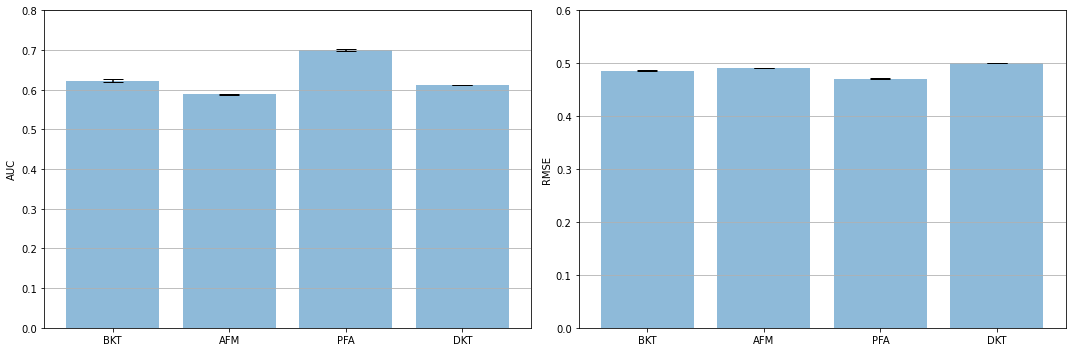

In [47]:
m = {'AUC': {'BKT': auc_bkt, 'AFM': auc_afm, 'PFA': auc_pfa, 'DKT': auc_dkt}, 'RMSE': {'BKT': rmse_bkt, 'AFM': rmse_afm, 'PFA': rmse_pfa, 'DKT': rmse_dkt}}
limits = {'AUC': 0.8, 'RMSE': 0.6}

plt.figure(figsize=(15, 5))

for metric_idx, metric_key in enumerate(m.keys()):
    
    # Create the subplot for the current metric
    plt.subplot(1, len(m), metric_idx + 1)
    # Compute means, standard deviations, and labels
    means, errors, labels = [], [], []
    for model_key, model_scores in m[metric_key].items():
        means.append(np.mean(model_scores))
        errors.append(np.std(model_scores))
        labels.append(model_key)
    
    # Plot values
    x_pos = np.arange(len(labels))
    plt.bar(x_pos, means, yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=10)
    # Make decorations
    plt.grid(axis='y')
    plt.xticks(x_pos, labels)
    plt.ylabel(metric_key)
    plt.ylim(0, limits[metric_key])

# Show the plot
plt.tight_layout()
plt.show()

### Task 3.2 Metrics discussion

From the left plot, it can be observed that the PFA model exhibited a higher AUC score (around 0.7) with respect to AFM, PFA and DKT models and a low standard deviation of AUC score across folds, indicating that the predictive power of the PFA model is higher across folds than the one of the other three models, when AUC is considered. 

Similarly, the right plot highlights that the PFA model performs better, on average, with respect to AFM, BKT and DKT in terms of RMSE, i.e., the RMSE score is lower for the PFA model (0.47). BKT, AFM and DKT were able to achieve an average RMSE score of 0.485, 0.49 and 0.5 respectively. The standard deviation in performance across folds is quite small for all models.       

Based on our results, we can generally observe that the characteristics and properties of the PFA model allow us to make better estimations of student’s subkect mastery, compared to the three other considered models. One reason behind this finding might be that the skills at hand seem to meet well PFA assumptions, specifically that (i) studetns may initially know more or less , (ii) students learn at the same rate, (iii) students learning rate differs for correct and wrong practive opportunitites, (iv) each item belongs to one or more skills. As we can see, leveraging prior failure and success opportunities (PFA) works much better than all other models.

### Learning Curves Comparison 
----

In this section, we fit a PFA (as soon as it achieved the best performance through all other models) model on all the skills. Then, for each skill we visually report and discuss (i) the learning curve and (ii) the bar plot representing the number of students who reached a given number of opportunities for that skill,  obtained with the PFA model fitted on the above-mentioned skills, in such a way that they can be easily and appropriately compared. 

This section is divided in three main tasks:
- Task 3.3: PFA fit and prediction. 
- Task 3.4: Learning curves and bar plots generation.
- Task 3.5: Learning curves and bar plots discussion. 

### Task 3.3 Fitting model and predicting

In [48]:
%time n_succ, n_fail = read_as_success_failure(df_topic)
%time X, y = prepare_data_pfa(skills, corrects, user_ids, n_succ, n_fail)

CPU times: user 4.74 s, sys: 491 ms, total: 5.23 s
Wall time: 12.7 s
CPU times: user 1.02 s, sys: 1.05 s, total: 2.07 s
Wall time: 6.28 s


In [49]:
# Initialize the model
pfa = CustomLogistic()

# Fit the model on the entire dataset
%time pfa.fit(X, y)

CPU times: user 5min 4s, sys: 1min 8s, total: 6min 12s
Wall time: 6min 14s


CustomLogistic()

In [50]:
# Make predictions
predictions_proba=pfa.predict_proba(X)

# Rename the dataframe columns as per instructions
predictions=df_topic[['user_id','skill_name','correct']].copy()
predictions.columns=['user_id','skill_name','y_true']
predictions['y_pred_pfa']=predictions_proba

In [51]:
predictions.head()

,user_id,skill_name,y_true,y_pred_pfa
1,387615,Large and lower case,1,0.39995
2,387615,Large and lower case,1,0.41648
3,387615,Large and lower case,0,0.41648
4,387615,Large and lower case,1,0.43321
5,387615,Large and lower case,0,0.42107


### Task 3.4 Learning curves visualization

In this task we visually report and discuss 

(i) the `learning curve` and 

(ii) the `bar plot` representing the number of students who reached a given number of opportunities, <br>
obtained by the PFA model fitted on that skill, in such a way that they can be easily and appropriately compared.

In [52]:
def avg_y_by_x(x, y):
    # Transform lists into arrays
    x = np.array(x)
    y = np.array(y)

    # Sort the integer id representing the number of opportunities in increasing order
    xs = sorted(list(set(x)))

    # Supporting lists to store the:
    # - xv: integer identifier of the number of opportunities
    # - yv: average value across students at that number of opportunities
    # - lcb and ucb: lower and upper confidence bound
    # - n_obs: number of observartions present at that number of opportunities (on per-skill plots, it is the #students)
    xv, yv, lcb, ucb, n_obs = [], [], [], [], []

    # For each integer identifier of the number of opportunities 0, ...
    for v in xs:
        ys = [y[i] for i, e in enumerate(x) if e == v] # We retrieve the values for that integer identifier
        if len(ys) > 0: 
            xv.append(v) # Append the integer identifier of the number of opportunities
            yv.append(sum(ys) / len(ys)) # Append the average value across students at that number of opportunities
            n_obs.append(len(ys)) # Append the number of observartions present at that number of opportunities

            
            # Prepare data for confidence interval computation
            unique, counts = np.unique(ys, return_counts=True)
            counts = dict(zip(unique, counts))

            if 0 not in counts:
                counts[0] = 0
            if 1 not in counts:
                counts[1] = 0

            # Calculate the 95% confidence intervals
            ci = sc.stats.beta.interval(0.95, 0.5 + counts[0], 0.5 + counts[1])
            lcb.append(ci[0])
            ucb.append(ci[1])

    return xv, yv, lcb, ucb, n_obs

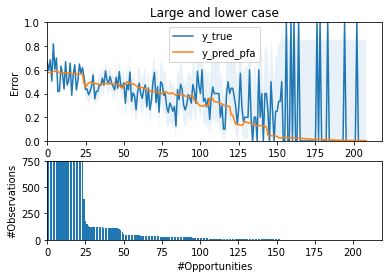

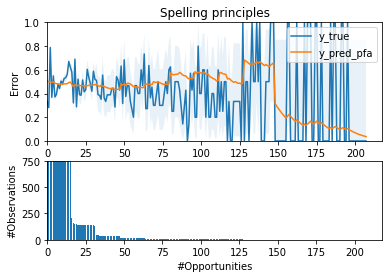

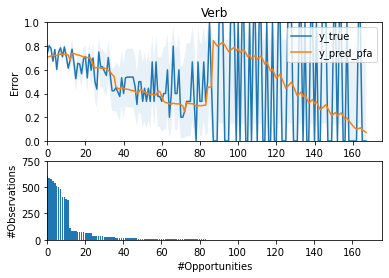

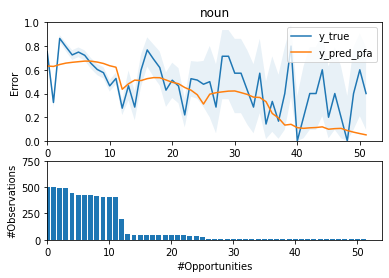

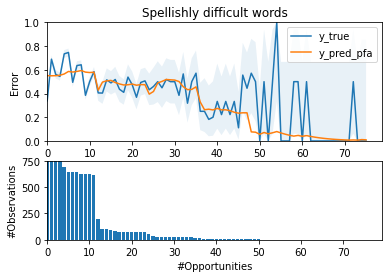

In [53]:
for plot_id, skill_name in enumerate(df_topic['skill_name'].unique()): # For each skill under consideration
    
    preds = predictions[predictions['skill_name'] == skill_name] # Retrieve predictions for the current skill

    xp = []
    yp = {}
    for col in preds.columns: # For y_true and and y_pred_pfa columns, initialize an empty list for curve values
        if 'y_' in col:
            yp[col] = []

    for user_id in preds['user_id'].unique(): # For each user
        user_preds = preds[preds['user_id'] == user_id] # Retrieve the predictions on the current skill for this user 
        xp += list(np.arange(len(user_preds))) # The x-axis values go from 0 to |n_opportunities|-1
        for col in preds.columns: 
            if 'y_' in col: # For y_true and and y_pred_pfa columns
                yp[col] += user_preds[col].tolist() # The y-axis value is the success rate for this user at that opportunity

    fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 2]}) # Initialize the plotting figure

    lines = []
    for col in preds.columns:
        if 'y_' in col: # For y_true and and y_pred_pfa columns   
            x, y, lcb, ucb, n_obs = avg_y_by_x(xp, yp[col]) # Calculate mean and 95% confidence intervals for success rate 
            y = [1-v for v in y] # Transform success rate in error rate
            if col == 'y_true': # In case of ground-truth data, we also show the confidence intervals
                axs[0].fill_between(x, lcb, ucb, alpha=.1)
            model_line, = axs[0].plot(x, y, label=col) # Plot the curve
            lines.append(model_line) # Store the line to then set the legend    

    # Make decorations for the learning curve plot
    axs[0].set_title(skill_name)
    axs[0].legend(handles=lines)
    axs[0].set_ylabel('Error')
    axs[0].set_ylim(0, 1)
    axs[0].set_xlim(0, None)

    # Plot the number of observations per number of opportunities bars and make decorations
    axs[1].set_xlabel('#Opportunities')
    axs[1].bar([i for i in range(len(n_obs))], n_obs)
    axs[1].set_ylabel('#Observations')
    axs[1].set_ylim(0, 750)
    axs[1].set_xlim(0, None)

    # Plot the learning curve and the bar plot 
    plt.show()

### Task 3.5 Learning curves discussion

- "**Large and lower case**". From the error rate in the ground-truth data (y_true, blue), it can be observed that this skill appears quite hard for students, with an initial error rate of around 0.6 in the first opportunity. The error rate goes slightly down, as we would usually expect, as much as the students play with the skill, reaching the lowest error rate of 0.17 at around 85 opportunities. Then it starts going up till 0.63 after 100 opportunities. But the overall trend is definitely deacreasing. It means that anyway during the course students learn something and this skill for them becomes easier. After 100 opportunities, the error rate starts jumping between 0 and a 1 just because there are only few students. In terms of confidence interval (blue area), it can be observed that the error rate is quite stable at the earlier stage. Starting from around 50 opportunities, the error rate is less stable probably due to the same reasons we provided above. The confidence interval finally becomes large when only few students keep playing with this skill for a higher number of opportunities. When it comes to consider the error rate obtained by the PFA model estimations (y_pred_pfa, orange), it can be observed that the model tends to be in the middle of real values keeping the trend. Looking at the bar plot at the bottom, students appear reasonably engaged with this skill for the first 25 opportunities, then the number of participants sharply decreases twice (at 25 and 50 #opportunisies) and after that it is slightly decreasing until there are just few students left.      

- "**Spelling principles**". Based on the patterns of the ground-truth data (y_true, blue), the error rate observed for this skill at the earlier stages is of around 0.52. The students thus don't know a lot about this topic. It can be explained by the fact that students doing this are beginners in German and have a lot of mistakes or by the difficulty of the topic. The error rate fluctuates around initial value for around 25 opportunities with small confidence interval. With higher numbers of opportunities  the error rate starts jumping between 0 and a 1 and the confidence interval significantly increases just because there are only few students. The predicted values are also quite stable until 75 opportunities and then it increases trying to catch changing behaviour of the value. THe bar plot shows almost the same situation as in previous skill (high value of interested students until 15 opportunities, then significant falls at 15 an 30 and then slow damping.

- "**Verb**". Based on the patterns of the ground-truth data (y_true, blue), the error rate observed for this skill at the earlier stages is of around 0.8. It means that the majority of students almost don't know anything at all about this topic. But with increasing number of opportunities the error rate falls firstly (until 20 #opportunities) with small confidence interval increasing it afterwards. It reaches minimum (0.2) around 60 number of opportunities and then due to the small number of users starts jumping between 0 and 1. All these facts mean that this tasks are well-designed and achieve the main goal-to teach students. The predicted curve starts around error rate equal to 0.7 and then goes down keeping the main trend and starts behave strange after 80 number of opportunities. The PFA model (y_pred_pfa, orange) is able to fit the ground-truth data very well across the number of opportunities, especially till around 60 opportunities. One important observation comes from the bar plot, which shows that the number of students involved in this skill dramatically goes down especially after 10-12 opportunities.

- "**Noun**". From the error rate in the ground-truth data (y_true, blue), it can be observed that this skill appears quite hard for students, with an initial error rate of around 0.7 in the first opportunity. And firstly this skill seems unclear that's why the error rate increases, but after 2-3 opportunities students starts improving until ~12 opportunities. During all this period the confidence interval is quite small. Afterwards the number of participants significantly falls, while the confidence interval increases. It should be mentioned that until the end the confidence interval is not small, but the value is not jumping from 0 to 1 as it was in previous plots. Predicted values in this skill are not really good, all the alternations cannot be well caught.

- "**Spellishly difficult words**". The last skill appears not so difficult at the beginning (~ 0.4), but after several opportunities it increases to error rate near to 0.8. It can be explained by the high threshold of starting this skill. After 11-12 opportunities when there are not so many participants the confidence interval becomes higher. The minimum value with a significant number of students it reaches around 38 opportunities (~0.25) and then an unpredictable behaviour starts. The predicted curve starts much higher (0.55) due to fluctuations of the real data on the first opportunities and then it is quite close to the true value until there are enough of students. This skill becomes a little bit abandones after 12 opportuniries and after that the number of participants slightly decreases.
 
Overall, comparing the considered five skills, "Spelling principles" seems to be a little bit going up (e.g., ill-defined skill or due to the type/difficulty of problems), while, for "Large and lower case", "Verb" and "Spellishly difficult words" have a decreasing trend. "Noun" skill trained with a lot fluctuations even though their is enough amount of data. Due to these fluctuations predicted values are not so good. For other skills I would say PFA model works quite well. There is a similar situation through all topicd about students involved in learning: a lot of participants until some number of opportunities and then a sharp fall.